next-steps checklist

(1) run on CALMS dataset
- GlobalTSNE: use your new InputSet for Columns; save templates + coords.
	- DONE!  updated functions to use the 'groups' and inputset functionality correctly
- GlobalKMeans: fit on templates; also run a few K values (e.g., 50/100/150) and save labels.
	- Done! Needing to update the 'assign' functionality, in order to use the correct filtering for groups
- GlobalWard: build linkage on the same templates; persist model.joblib/.npz.
	- Done!

(2) visualizations (CALMS)
 - t-SNE scatter colored by k-means (pick K) and by Ward recut (choose cut).
	- Done!
 - t-SNE scatter colored by ground truth labels (Columns GT).
	Need to create appropriate way to save labels for the calms dataset
	- Done!
 - Raster/time plots per (seq, persp) for k-means, Ward, and GT.

(3) compare clustering vs GT
 - Confusion matrices: GT vs (k-means, Ward cut).
 - Basic metrics: NMI/ARI, cluster purity, per-class recall.
 - Per-cluster thumbnails: top-N frames per cluster to sanity-check.
	- Done!

(5) model training (start simple)
 - XGBoost classifier on standardized feature space (same inputset/scaler).
 - Train on Columns GT; log CV metrics; save model + scaler + params.
 - Add fast inference path (NearestNeighbors to centroids as baseline).

(6) video segment browsing
 - Utility: map cluster or GT labels → contiguous segments (min-length merge).
 - Viewer: given (seq, persp, t0..t1) open video slice (or export list).

(7) cross-dataset transfer (Columns → ESI)
 - Reuse Columns scaler + model; standardize ESI with same inputset.
 - Predict ESI labels; export per-(seq, persp) label tracks.
 - Spot-check with t-SNE overlay (ESI points, colored by predicted label).


(9) small automation
 - Notebook cells → scripts (CLI): run_tsne, run_kmeans, run_ward, viz_tsne, viz_raster.
 - Add a simple make/bash pipeline to reproduce a full experiment from an inputset.

In [4]:
import pandas as pd
import numpy as np
import os
from pathlib import Path


In [5]:
import importlib
import dataset as ds
import features
importlib.reload(ds)
importlib.reload(features)

<module 'features' from '/Users/jacob/Documents/GitHub/EcodylicScience/behavior/features.py'>

Centralized notebook for calling other function

# Datasets and operations

# CALMS21

In [3]:
name = "calms21"
# Choose a base directory (will be created if it doesn't exist)
base = "/Volumes/JD-SSD/mice_data/calms21/dataset/"
# Only include roots you actually need right now:

manifest_path = ds.new_dataset_manifest(
    name=name,
    base_dir=base,
    version="0.1.0",
    index_format="group/sequence",
)
print(Path(manifest_path).read_text().splitlines()[:30])  # peek first lines

Wrote dataset manifest -> /Volumes/JD-SSD/mice_data/calms21/dataset/dataset.yaml


NameError: name 'Path' is not defined

### Load existing

In [6]:
# Load existing manifest
manifest_path = '/Volumes/JD-SSD/mice_data/calms21/dataset/dataset.yaml'
importlib.reload(ds)
dataset = ds.Dataset(manifest_path)
dataset.load()

Dataset(manifest_path='/Volumes/JD-SSD/mice_data/calms21/dataset/dataset.yaml', name='calms21', version='0.1.0', format='yaml', roots={'media': '/Volumes/JD-SSD/mice_data/calms21/dataset/media', 'features': '/Volumes/JD-SSD/mice_data/calms21/dataset/features', 'labels': '/Volumes/JD-SSD/mice_data/calms21/dataset/labels', 'models': '/Volumes/JD-SSD/mice_data/calms21/dataset/models', 'tracks': '/Volumes/JD-SSD/mice_data/calms21/dataset/tracks', 'tracks_raw': '/Volumes/JD-SSD/mice_data/calms21/dataset/tracks_raw'}, meta={})

### Index and convert

In [5]:
# Index videos (no symlinks, just absolute paths in media/index.csv)
dataset.index_media(
    search_dirs=[
        "/Volumes/JD-SSD/mice_data/calms21/task1_videos_mp4/",
    ],
    extensions=(".mp4", ".avi")
)
dataset.index_tracks_raw(
    search_dirs=["/Volumes/JD-SSD/mice_data/calms21/data"],
    patterns="calms*.npy",       
    src_format="calms21_npy",
    multi_sequences_per_file=True,
    group_from="filename"
)

[index_media] Wrote 91 entries -> /Volumes/JD-SSD/mice_data/calms21/dataset/media/index.csv
[index_tracks_raw] 6 -> /Volumes/JD-SSD/mice_data/calms21/dataset/tracks_raw/index.csv


PosixPath('/Volumes/JD-SSD/mice_data/calms21/dataset/tracks_raw/index.csv')

In [ ]:
dataset.convert_all_tracks(params={"neck_idx": None, "tail_idx": None}, overwrite=True, group_from='filename')

In [41]:
dataset.convert_all_labels(kind="behavior")

[convert_all_labels] kind=behavior wrote 292 sequences (overwrite=False).


In [5]:
dataset.list_sequences()

['task1/test/mouse071_task1_annotator1',
 'task1/test/mouse072_task1_annotator1',
 'task1/test/mouse073_task1_annotator1',
 'task1/test/mouse074_task1_annotator1',
 'task1/test/mouse075_task1_annotator1',
 'task1/test/mouse076_task1_annotator1',
 'task1/test/mouse077_task1_annotator1',
 'task1/test/mouse078_task1_annotator1',
 'task1/test/mouse079_task1_annotator1',
 'task1/test/mouse080_task1_annotator1',
 'task1/test/mouse081_task1_annotator1',
 'task1/test/mouse082_task1_annotator1',
 'task1/test/mouse083_task1_annotator1',
 'task1/test/mouse084_task1_annotator1',
 'task1/test/mouse085_task1_annotator1',
 'task1/test/mouse086_task1_annotator1',
 'task1/test/mouse087_task1_annotator1',
 'task1/test/mouse088_task1_annotator1',
 'task1/test/mouse089_task1_annotator1',
 'task1/train/mouse001_task1_annotator1',
 'task1/train/mouse002_task1_annotator1',
 'task1/train/mouse003_task1_annotator1',
 'task1/train/mouse004_task1_annotator1',
 'task1/train/mouse005_task1_annotator1',
 'task1/tra

## Features

### PoseDistance and Wavelet

In [22]:
import features
importlib.reload(features)
feat = features.PairPoseDistancePCA(params={
    "n_components": 6,
    "pose_n": 7,
})
run_id = dataset.run_feature(feat, groups=['calms21_task1_train'])

[feature:pair-posedistance-pca] completed run_id=0.1-d2cdb45ffd -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-posedistance-pca/0.1-d2cdb45ffd


/Users/jacob/Documents/GitHub/EcodylicScience/behavior/dataset.py:1453: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-11-12T07:14:08.153592+00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[sel, "finished_at"] = str(finished_at)


In [23]:
feat_wav = features.PairWavelet(params={
    "fps_default": 30.0,
    "f_min": 0.2,
    "f_max": 5.0,
    "n_freq": 25,
    "wavelet": "cmor1.5-1.0",
    "log_floor": -3.0,
})
wav_run = dataset.run_feature(
    feat_wav,
    input_kind="feature",
    input_feature="pair-posedistance-pca",   # name of prior feature
    # optionally scope by groups or sequences:
    groups=['calms21_task1_train']
)

[feature:pair-wavelet__from__pair-posedistance-pca] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-wavelet__from__pair-posedistance-pca/0.1-88d79630c2


### Pair-Egocentric and Wavelet

In [70]:
feat = features.PairEgocentricFeatures(params={
    "neck_idx": 3,
    "tail_base_idx": 6,
    # "fps_default": 30.0,
})
run_id = dataset.run_feature(feat, groups=["calms21_task1_train"],overwrite=True)

[feature:pair-egocentric] completed run_id=0.1-5f7ddf53ba -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-egocentric/0.1-5f7ddf53ba


In [12]:
## wavelet (refine so can change parameters)
feat_wav = features.PairWavelet(params={
    "fps_default": 30.0,
    "f_min": 0.2,
    "f_max": 5.0,
    "n_freq": 25,
    "wavelet": "cmor1.5-1.0",
    "log_floor": -3.0,
})
wav_run = dataset.run_feature(
    feat_wav,
    input_kind="feature",
    input_feature="pair-egocentric",   # name of prior feature
    input_run_id=None,                     # or a specific run_id; None => latest
    # optionally scope by groups or sequences:
    groups=['calms21_task1_train']
)

[feature:pair-wavelet__from__pair-egocentric] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/pair-wavelet__from__pair-egocentric/0.1-88d79630c2


/Users/jacob/Documents/GitHub/EcodylicScience/behavior/dataset.py:1453: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-11-12T06:57:02.880364+00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[sel, "finished_at"] = str(finished_at)


### TSNE

In [32]:
import gc
gc.collect()

29061

In [33]:
import importlib, features
importlib.reload(features)

inputs = [
    {
        "feature": "pair-wavelet__from__pair-posedistance-pca",
        "run_id": None,
        "pattern": "*parquet",
        "load": {"kind": "parquet", "transpose": False},
    },
    {
        "feature": "pair-wavelet__from__pair-egocentric",
        "run_id": None,
        "pattern": "*parquet",
        "load": {"kind": "parquet", "transpose": False},
    },
]

# one-time (or overwrite=True to update) – writes <dataset_root>/inputsets/social+ego@v1.json
features.save_inputset(dataset, "social+ego@v1", inputs, overwrite=True)


PosixPath('/Volumes/JD-SSD/mice_data/calms21/dataset/inputsets/social%2Bego%40v1.json')

In [34]:
feat_tsne = features.GlobalTSNE(params={
    "inputset": "social+ego@v1",
    "total_templates": 2000,
    "perplexity": 50,
    "n_jobs": 8,
})

tsne_run = dataset.run_feature(feat_tsne, input_kind="inputset", input_feature="social+ego@v1", groups=['calms21_task1_train'])
print("tsne run:", tsne_run)

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


[feature:global-tsne__from__social+ego@v1] completed run_id=0.2-703e72498f -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-tsne__from__social+ego@v1/0.2-703e72498f
tsne run: 0.2-703e72498f


/Users/jacob/Documents/GitHub/EcodylicScience/behavior/dataset.py:1670: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2025-11-12T08:07:17.154017+00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


## Clustering

### k-means

In [37]:
# on pair-egocentric
import importlib, features
importlib.reload(features)

k = 100
feat = features.GlobalKMeansClustering(params={
    "k": k,
    "artifact": {  # fit ON pair-egocentric parquet
        "feature": "pair-egocentric",
        "run_id": None,
        "pattern": "*parquet",
        "load": {"kind": "parquet", "numeric_only": True}
    },
    # optional: also write NPZ labels into this kmeans run
    "assign": {
        "inputs": [
            {
                "feature": "pair-egocentric",
                "run_id": None,
                "pattern": "*parquet",
                "load": {"kind": "parquet", "numeric_only": True}
            }
        ]
    }
})

kmeans_run_id = dataset.run_feature(
    feat,
    input_kind="feature",
    input_feature="pair-egocentric",  # streams pair-egocentric frames to transform()
    groups=['calms21_task1_train']
)
print("kmeans run_id:", kmeans_run_id)

KeyboardInterrupt: 

In [42]:
import importlib, features
importlib.reload(features)

feat_kmeans = features.GlobalKMeansClustering(params={
    "k": 50,
    "artifact": {
        "feature": "global-tsne__from__social+ego@v1",
        "run_id": None,
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
    "label_artifact_points": True,
    "assign": {
        "scaler": {
            "feature": "global-tsne__from__social+ego@v1",
            "run_id": None,
            "pattern": "global_opentsne_embedding.joblib",
            "key": "scaler",
        },
        "inputset": "social+ego@v1",
    },
})
kmeans_run_id = dataset.run_feature(
    feat_kmeans,
    input_kind="feature",
    input_feature="global-tsne__from__social+ego@v1",
    groups=['calms21_task1_train']
)
print("kmeans run:", kmeans_run_id)



[feature:global-kmeans__from__global-tsne__from__social+ego@v1] completed run_id=0.3-8cdda94ab0 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-kmeans__from__global-tsne__from__social+ego@v1/0.3-8cdda94ab0
kmeans run: 0.3-8cdda94ab0


### Ward clustering

In [14]:
input_tsne_feature = "global-tsne__from__social+ego@v1"

# fit Ward on the templates saved by your TSNE run
feat_ward = features.GlobalWardClustering(params={
    "artifact": {
        "feature": input_tsne_feature,
        "run_id": None,  # or None to pick “latest finished”
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
})
ward_run = dataset.run_feature(
    feat_ward,
    input_kind="feature",
    input_feature=input_tsne_feature,
)
print("ward run:", ward_run)

[feature:global-ward__from__global-tsne__from__social+ego@v1] completed run_id=0.1-a3746fba33 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/global-ward__from__global-tsne__from__social+ego@v1/0.1-a3746fba33
ward run: 0.1-a3746fba33


## Visualization

In [24]:
from pathlib import Path
import json
from dataset import _inputset_path, _feature_run_root, _latest_feature_run_root
from features import _load_array_from_spec

def summarize_inputset_dims(ds, name):
    path = _inputset_path(ds, name)
    data = json.loads(path.read_text())
    specs = data.get("inputs") or []
    print(f"Inputset '{name}' ({len(specs)} specs)")
    for spec in specs:
        feat = spec["feature"]
        run_id = spec.get("run_id")
        if run_id is None:
            run_id, run_root = _latest_feature_run_root(ds, feat)
        else:
            run_root = _feature_run_root(ds, feat, run_id)
        pattern = spec.get("pattern", "*.parquet")
        load = spec.get("load", {"kind": "parquet", "transpose": False})
        files = sorted(run_root.glob(pattern))
        if not files:
            print(f"  - {feat} (run {run_id}): no files match {pattern}")
            continue
        arr = _load_array_from_spec(files[0], load)
        print(f"  - {feat} (run {run_id}): {arr.shape} -> {arr.shape[1]} features")

# Usage (assuming `dataset` is your Dataset instance):
summarize_inputset_dims(dataset, "social+ego@v1")


Inputset 'social+ego@v1' (2 specs)
  - pair-wavelet__from__pair-posedistance-pca (run 0.1-88d79630c2): (42728, 152) -> 152 features
  - pair-wavelet__from__pair-egocentric (run 0.1-88d79630c2): (47620, 377) -> 377 features


[feature:ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1] completed run_id=0.1-f34589737b -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/ward-assign__from__global-ward__from__global-tsne__from__social+ego@v1/0.1-f34589737b
ward-assign run: 0.1-f34589737b
[feature:viz-global-colored__from__global-tsne__from__social+ego@v1] completed run_id=0.1-603977f456 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/viz-global-colored__from__global-tsne__from__social+ego@v1/0.1-603977f456
viz run: 0.1-603977f456


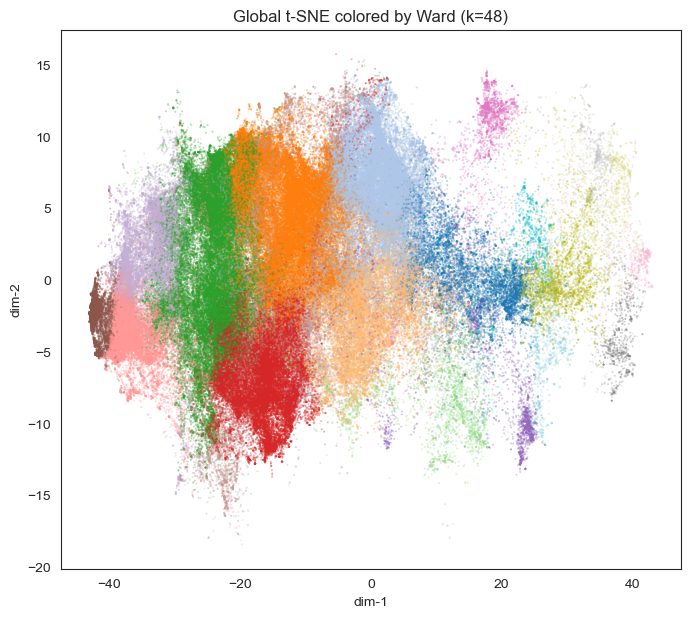

In [32]:
input_tsne_feature = "global-tsne__from__social+ego@v1"

import importlib, features
importlib.reload(features)

ward_assign = features.WardAssignClustering(params={
    "ward_model": {
        "feature": f"global-ward__from__{input_tsne_feature}",
        "run_id": ward_run,
        "pattern": "model.joblib",
    },
    "artifact": {
        "feature": input_tsne_feature,
        "run_id": None,
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
    "scaler": {
        "feature": input_tsne_feature,
        "run_id": None,
        "pattern": "global_opentsne_embedding.joblib",
        "key": "scaler",
    },
    "inputset": "social+ego@v1",
    "n_clusters": 20,
    "recalc": False,
})

ward_assign_run = dataset.run_feature(
    ward_assign,
    input_kind="inputset",
    input_feature="social+ego@v1",   # tells the runner which inputset drives scope/streaming
    groups=["calms21_task1_train"],  # optional scope filter
)
print("ward-assign run:", ward_assign_run)



viz = features.VizGlobalColored(params={
    "coords": {
        "feature": input_tsne_feature,
        "run_id": None,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": "ward-assign__from__global-ward__from__"+input_tsne_feature,
        "run_id": ward_assign_run,
        "pattern": "*.parquet",
        "load": {"kind": "parquet", "numeric_only": False, "columns": ["cluster"]},
    },
    "coord_key_regex": r"seq=(.+?)(?:_persp=.*)?$",
    "label_key_regex": None,
    "title": "Global t-SNE colored by Ward (k=48)",
})

viz_run_id = dataset.run_feature(viz, input_kind="feature", input_feature=input_tsne_feature)
print("viz run:", viz_run_id)

[feature:viz-global-colored__from__global-tsne__from__social+ego@v1] completed run_id=0.1-c84e99219b -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/viz-global-colored__from__global-tsne__from__social+ego@v1/0.1-c84e99219b


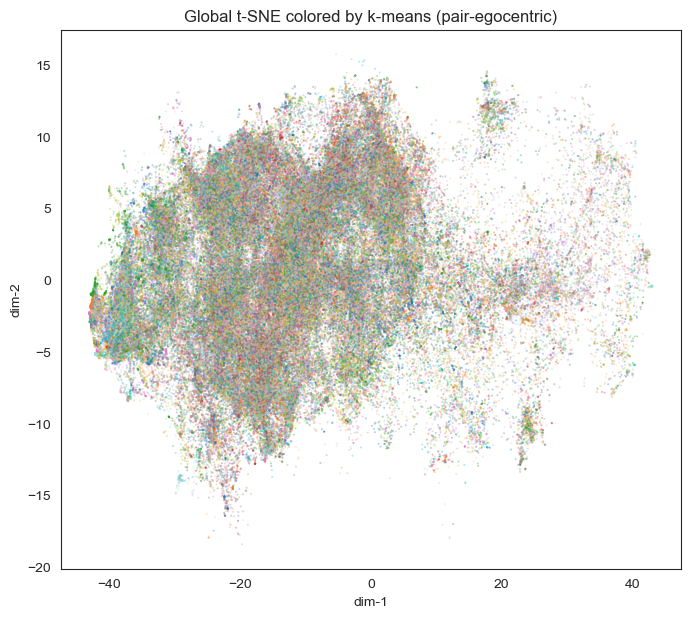

In [38]:
import importlib, features
importlib.reload(features)

viz = features.VizGlobalColored(params={
    "coords": {
        "feature": input_tsne_feature,  # e.g. "global-tsne__from__social+ego@v1"
        "run_id": None,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": "global-kmeans__from__pair-egocentric",
        "run_id": None,
        "pattern": "*.parquet",
        "load": {"kind": "parquet", "numeric_only": False, "columns": ["cluster"]},
    },
    "coord_key_regex": r"seq=(.+)$",
    "label_key_regex": None,  # re-use dataset-derived sequence map (same as coords)
    "plot_max": 200_000,
    "title": "Global t-SNE colored by k-means (pair-egocentric)",
})

run_id = dataset.run_feature(viz, input_kind="feature", input_feature=input_tsne_feature)


[feature:viz-global-colored__from__global-tsne__from__social+ego@v1] completed run_id=0.1-050092b5a3 -> /Volumes/JD-SSD/mice_data/calms21/dataset/features/viz-global-colored__from__global-tsne__from__social+ego@v1/0.1-050092b5a3


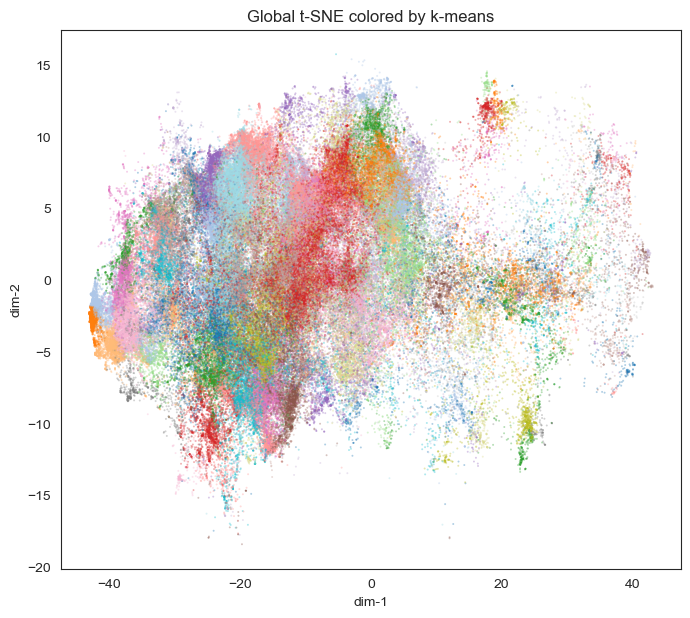

In [36]:
import importlib, features
importlib.reload(features)

viz = features.VizGlobalColored(params={
    "coords": {
        "feature": input_tsne_feature,
        "run_id": None,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": f"global-kmeans__from__{input_tsne_feature}",
        "run_id": None,
        "pattern": "global_kmeans_labels_seq=*.npz",
        "load": {"kind": "npz", "key": "labels"},
    },
    "coord_key_regex": r"seq=(.+)$",
    "label_key_regex": r"seq=(.+)$",
    "plot_max": 200_000,
    "title": "Global t-SNE colored by k-means",
})

run_id = dataset.run_feature(viz, input_kind="feature", input_feature=input_tsne_feature)


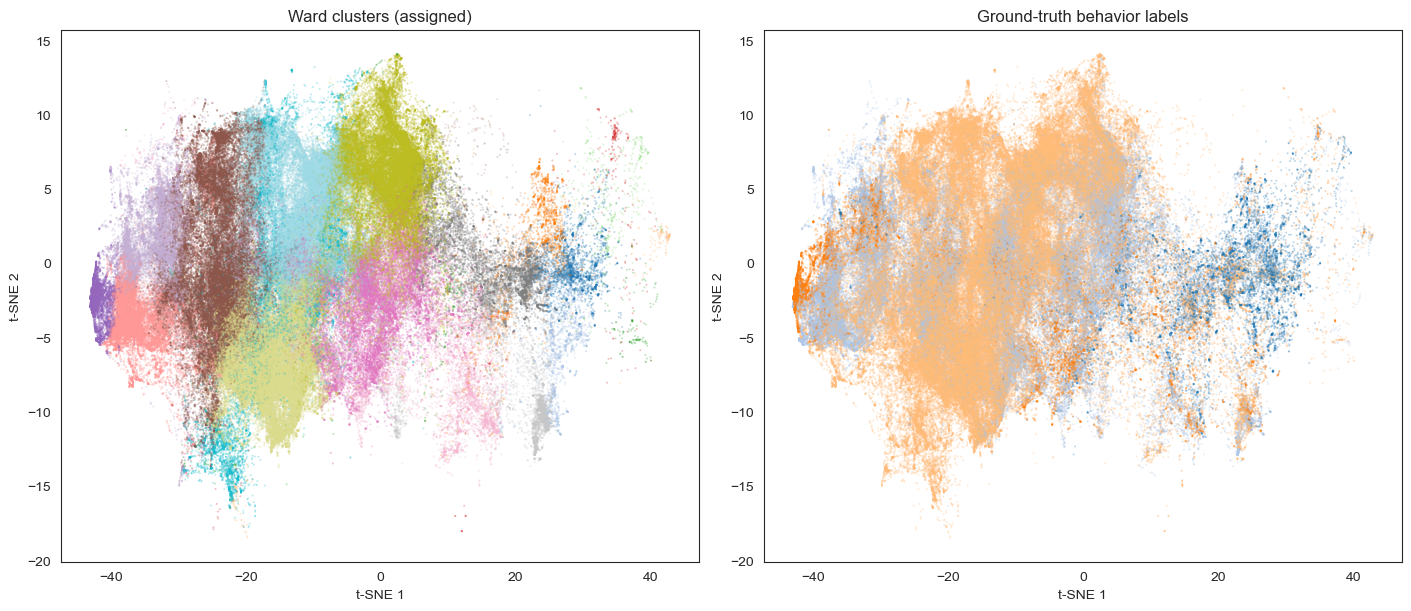

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path

# --- configure the runs you want to compare ---
tsne_feature = "global-tsne__from__social+ego@v1"
tsne_run     = "0.2-703e72498f"      # reuse whatever run_id you already captured
ward_feature = f"ward-assign__from__global-ward__from__{tsne_feature}"
ward_run     = "0.1-f34589737b"  # run_id returned by the WardAssignClustering call
label_kind   = "behavior"      # standardized CALMS21 task-1 labels
plot_max     = 300_000
rng          = np.random.default_rng(42)

sns.set_style("white")

# --- resolve paths and indexes ---
features_root = dataset.get_root("features")
coords_root   = features_root / tsne_feature / tsne_run
ward_root     = features_root / ward_feature
ward_idx      = pd.read_csv(ward_root / "index.csv")
ward_idx      = ward_idx[ward_idx["run_id"].astype(str) == str(ward_run)]
ward_map      = dict(zip(ward_idx["sequence_safe"], ward_idx["abs_path"]))

labels_root   = dataset.get_root("labels") / label_kind
labels_idx    = pd.read_csv(labels_root / "index.csv")
label_map     = dict(zip(labels_idx["sequence_safe"], labels_idx["abs_path"]))

coord_files   = sorted(coords_root.glob("global_tsne_coords_seq=*.npz"))
pat           = re.compile(r"global_tsne_coords_seq=(.+)\.npz")

Y_blocks, ward_blocks, gt_blocks = [], [], []
for fp in coord_files:
    m = pat.match(fp.name)
    if not m:
        continue
    safe_seq = m.group(1)
    if safe_seq not in ward_map or safe_seq not in label_map:
        continue  # skip sequences missing either label source

    Y = np.load(fp)["Y"]
    ward_df = pd.read_parquet(Path(ward_map[safe_seq]))
    ward_labels = ward_df["cluster"].to_numpy()

    gt_bundle = np.load(label_map[safe_seq], allow_pickle=True)
    gt_labels = gt_bundle["labels"].astype(int)

    n = min(len(Y), len(ward_labels), len(gt_labels))
    if n == 0:
        continue

    Y_blocks.append(Y[:n])
    ward_blocks.append(ward_labels[:n])
    gt_blocks.append(gt_labels[:n])

if not Y_blocks:
    raise RuntimeError("No overlapping sequences between coords, Ward labels, and behavior labels.")

Y_all   = np.vstack(Y_blocks)
ward_all= np.concatenate(ward_blocks)
gt_all  = np.concatenate(gt_blocks)

if Y_all.shape[0] > plot_max:
    idx = rng.choice(Y_all.shape[0], size=plot_max, replace=False)
    Y_plot, ward_plot, gt_plot = Y_all[idx], ward_all[idx], gt_all[idx]
else:
    Y_plot, ward_plot, gt_plot = Y_all, ward_all, gt_all

# --- quick color helper ---
def scatter_categorical(ax, coords, labels, title):
    sns.scatterplot(
        x=coords[:, 0],
        y=coords[:, 1],
        hue=labels.astype(int),
        palette="tab20",
        s=2,
        alpha=0.3,
        linewidth=0,
        ax=ax,
        legend=False,
    )
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
scatter_categorical(axes[0], Y_plot, ward_plot, "Ward clusters (assigned)")
scatter_categorical(axes[1], Y_plot, gt_plot,   "Ground-truth behavior labels")
plt.show()


In [48]:
import analysis
importlib.reload(analysis)

# n_clusters = 50
# input_tsne_feature = "global-tsne__from__social+ego@v1"

# import importlib, features
# importlib.reload(features)

# ward_assign = features.WardAssignClustering(params={
#     "ward_model": {
#         "feature": f"global-ward__from__{input_tsne_feature}",
#         "run_id": None,
#         "pattern": "model.joblib",
#     },
#     "artifact": {
#         "feature": input_tsne_feature,
#         "run_id": None,
#         "pattern": "global_templates_features.npz",
#         "load": {"kind": "npz", "key": "templates"},
#     },
#     "scaler": {
#         "feature": input_tsne_feature,
#         "run_id": None,
#         "pattern": "global_opentsne_embedding.joblib",
#         "key": "scaler",
#     },
#     "inputset": "social+ego@v1",
#     "n_clusters": n_clusters,
#     "recalc": False,
# })

# ward_assign_run = dataset.run_feature(
#     ward_assign,
#     input_kind="inputset",
#     input_feature="social+ego@v1",   # tells the runner which inputset drives scope/streaming
#     groups=["calms21_task1_train"],  # optional scope filter
# )
# print("ward-assign run:", ward_assign_run)

metrics = analysis.compute_cluster_label_agreement(
    dataset,
    cluster_feature=f"global-kmeans__from__{tsne_feature}",
    cluster_run_id=kmeans_run_id,
    label_kind="behavior",
    max_frames=None,
    include_per_sequence=True,
)
display(metrics["metrics"])        # overall dict with confusion + mapping
# pd.DataFrame(metrics["per_sequence"]).sort_values("ARI")


{'n_samples': 507738,
 'n_classes': 4,
 'n_clusters': 50,
 'ARI': 0.03536518101196643,
 'AMI': 0.13213315933561787,
 'homogeneity': 0.29971009601888504,
 'completeness': 0.08479792239203628,
 'v_measure': 0.13219382819298464,
 'purity': 0.7084618444946016,
 'hungarian_accuracy': 0.1538037334215678,
 'confusion': array([[    0,  2743,    85,   272,   517,  1127,    72,    28,     0,
            99,   261,  2285,   523,     0,   636,    60,   307,   207,
             0,     0,     0,     7,   326,     0,     0,   126,     0,
            84,     0,  1547,   578,     0,   125,   376,   123,    31,
             0,   427,     0,     0,    13,     0,     0,     0,   158,
            27,   796,    37,    36,     0],
        [   38,   595, 11807,  5185,    84,  3229,  8981,  8476,  3060,
           124,  2024,  4622,   698,    10, 15514,    11, 21758,    41,
           890,   245,  3618,  5540,   949,    77,  2445,    95,    11,
            28,  3410,   546,   183,     0,   129, 12814,  2404,  

In [53]:
importlib.reload(analysis)

kmeans_feature = f"global-kmeans__from__{tsne_feature}"
kmeans_runs = analysis.list_feature_runs(dataset, kmeans_feature)
display(kmeans_runs[["run_id", "k", "finished_at"]])

run_id    k                       finished_at
0  0.3-8cdda94ab0   50  2025-11-13T09:40:01.520206+00:00
1  0.3-f1ab17d641  100  2025-11-13T09:39:52.114279+00:00
2  0.3-7c634f462b  150  2025-11-12T08:43:31.064514+00:00

In [51]:
del compute_cluster_label_agreement
del list_feature_runs

In [56]:
kmeans_feature = f"global-kmeans__from__{tsne_feature}"
kmeans_runs = analysis.list_feature_runs(dataset, kmeans_feature)
display(kmeans_runs[["run_id", "k", "finished_at"]])

for _, row in kmeans_runs.iterrows():
    metrics = analysis.compute_cluster_label_agreement(
        dataset,
        cluster_feature=kmeans_feature,
        cluster_run_id=row.run_id,
        label_kind="behavior",
        include_per_sequence=False,
    )
    print(row.k, metrics["metrics"]["AMI"], metrics["metrics"]["homogeneity"])


run_id    k                       finished_at
0  0.3-8cdda94ab0   50  2025-11-13T09:40:01.520206+00:00
1  0.3-f1ab17d641  100  2025-11-13T09:39:52.114279+00:00
2  0.3-7c634f462b  150  2025-11-12T08:43:31.064514+00:00

50 0.13213315933561787 0.29971009601888504
100 0.12858994373373298 0.33212118156358855
150 0.12558785447023543 0.34678210244214247


# CRIMS 13
https://data.caltech.edu/records/4emt5-b0t10


# ESI 11-11

In [17]:
name = "esi11-11"
# Choose a base directory (will be created if it doesn't exist)
base = "/Volumes/JD-SSD/ESI-mice/dataset1/"

manifest_path = ds.new_dataset_manifest(
    name=name,
    base_dir=base,
    version="0.1.0",
    index_format="group/sequence",
)
print(Path(manifest_path).read_text().splitlines()[:30])  # peek first lines

Wrote dataset manifest -> /Volumes/JD-SSD/ESI-mice/dataset1/dataset.yaml
['# ==========================================================', '# DATASET MANIFEST (extensible YAML)', '# Minimal required fields above; append optional fields below', '# Common OPTIONAL fields you may add later:', '#   fps_default: 30.0', '#   resolution_default: [1920, 1080]', '#   n_animals_default: 2', '#   species: ""', '#   groups:                      # [{id, notes, condition, date, ...}]', '#   sequences:                   # [{id, group, media_path, pose_path, fps, n_frames, n_animals, ...}]', '#   splits:                      # {task1_train: [...], task1_test: [...], ...}', '#   labels_map:                  # {0: attack, 1: investigation, ...}', '#   skeleton:                    # [[p1, p2], ...]', '#   bodyparts:                   # ["snout","neck",...]', '#   processing:                  # [{step, time, params_hash, code_commit, ...}]', '#   pose_model:                  # {name, engine, checkpoint, co

## Load existing

In [43]:
base = "/Volumes/JD-SSD/ESI-mice/dataset1/"
importlib.reload(ds)
dataset = ds.Dataset(base)
dataset.load()
# Index native TRex NPZs (per id)
dataset.index_tracks_raw(
    search_dirs=["/Volumes/JD-SSD/ESI-mice/data"],
    patterns="*.npz",
    src_format="trex_npz",
    multi_sequences_per_file=False
)
dataset.convert_all_tracks(merge_per_sequence=True)


[index_tracks_raw] 4 -> /Volumes/JD-SSD/ESI-mice/dataset1/tracks_raw/index.csv


In [67]:
dataset.list_sequences()

['concat_2024-11-11']

### PoseDistance and Wavelet

In [27]:
#### PoseDistance and Wavelet
feat = features.PairPoseDistancePCA(params={
    "n_components": 6,
    "pose_n": 7
})
run_id = dataset.run_feature(feat)

feat_wav = features.PairWavelet(params={
    "fps_default": 30.0,
    "f_min": 0.2,
    "f_max": 5.0,
    "n_freq": 25,
    "wavelet": "cmor1.5-1.0",
    "log_floor": -3.0,
})
wav_run = dataset.run_feature(
    feat_wav,
    input_kind="feature",
    input_feature="pair-posedistance-pca",   # name of prior feature
    input_run_id=None,                     # or a specific run_id; None => latest
    # optionally scope by groups or sequences:
    # groups=['calms21_task1_train']
)

[feature:pair-posedistance-pca] completed run_id=0.1-d2cdb45ffd -> /Volumes/JD-SSD/ESI-mice/dataset1/features/pair-posedistance-pca/0.1-d2cdb45ffd
[feature:pair-wavelet__from__pair-posedistance-pca] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/pair-wavelet__from__pair-posedistance-pca/0.1-88d79630c2


### Pair-Egocentric and Wavelet

In [28]:
feat = features.PairEgocentricFeatures(params={
    "neck_idx": 3,
    "tail_base_idx": 6,
    # optional overrides:
    # "center_mode": "mean",
    # "fps_default": 30.0,
    # "smooth_win": 0,
})
run_id = dataset.run_feature(feat)


## wavelet (refine so can change parameters)
feat_wav = features.PairWavelet(params={
    "fps_default": 30.0,
    "f_min": 0.2,
    "f_max": 5.0,
    "n_freq": 25,
    "wavelet": "cmor1.5-1.0",
    "log_floor": -3.0,
})
wav_run = dataset.run_feature(
    feat_wav,
    input_kind="feature",
    input_feature="pair-egocentric",   # name of prior feature
    input_run_id=None,                     # or a specific run_id; None => latest
    # optionally scope by groups or sequences:
    # groups=['calms21_task1_train']
)

[feature:pair-egocentric] completed run_id=0.1-5f7ddf53ba -> /Volumes/JD-SSD/ESI-mice/dataset1/features/pair-egocentric/0.1-5f7ddf53ba
[feature:pair-wavelet__from__pair-egocentric] completed run_id=0.1-88d79630c2 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/pair-wavelet__from__pair-egocentric/0.1-88d79630c2


### TSNE

In [26]:
import importlib, features
importlib.reload(features)

inputs = [
    {
        "feature": "pair-wavelet__from__pair-posedistance-pca",
        "run_id": None,
        "pattern": "*parquet",
        "load": {"kind": "parquet", "transpose": False},
    },
    {
        "feature": "pair-wavelet__from__pair-egocentric",
        "run_id": None,
        "pattern": "*parquet",
        "load": {"kind": "parquet", "transpose": False},
    },
]

# one-time (or overwrite=True to update) – writes <dataset_root>/inputsets/social+ego@v1.json
features.save_inputset(dataset, "social+ego@v1", inputs, overwrite=True)




PosixPath('/Volumes/JD-SSD/ESI-mice/dataset1/inputsets/social%2Bego%40v1.json')

In [10]:
feat_tsne = features.GlobalTSNE(params={
    "inputset": "social+ego@v1",
    "total_templates": 2000,
    "perplexity": 50,
    "n_jobs": 8,
})

tsne_run = dataset.run_feature(feat_tsne)
print("tsne run:", tsne_run)

[feature:global-tsne] completed run_id=0.2-703e72498f -> /Volumes/JD-SSD/ESI-mice/dataset1/features/global-tsne/0.2-703e72498f
tsne run: 0.2-703e72498f


## Clustering

### k-means

In [4]:
# on pair-egocentric
import importlib, features
importlib.reload(features)

k = 100
feat = features.GlobalKMeansClustering(params={
    "k": k,
    "artifact": {  # fit ON pair-egocentric parquet
        "feature": "pair-egocentric",
        "run_id": None,
        "pattern": "*parquet",
        "load": {"kind": "parquet", "numeric_only": True}
    },
    # optional: also write NPZ labels into this kmeans run
    "assign": {
        "inputs": [
            {
                "feature": "pair-egocentric",
                "run_id": None,
                "pattern": "*parquet",
                "load": {"kind": "parquet", "numeric_only": True}
            }
        ]
    }
})

run_id = dataset.run_feature(
    feat,
    input_kind="feature",
    input_feature="pair-egocentric",  # streams pair-egocentric frames to transform()
)
print("kmeans run_id:", run_id)

[feature:global-kmeans__from__pair-egocentric] completed run_id=0.3-92361714cd -> /Volumes/JD-SSD/ESI-mice/dataset1/features/global-kmeans__from__pair-egocentric/0.3-92361714cd
kmeans run_id: 0.3-92361714cd


In [7]:
import importlib, features
importlib.reload(features)

feat_kmeans = features.GlobalKMeansClustering(params={
    "k": 150,
    "artifact": {
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
    "label_artifact_points": True,
    "assign": {
        "scaler": {
            "feature": "global-tsne",
            "run_id": None,
            "pattern": "global_opentsne_embedding.joblib",
            "key": "scaler",
        },
        "inputset": "social+ego@v1",
    },
})
kmeans_run = dataset.run_feature(
    feat_kmeans,
    input_kind="feature",
    input_feature="global-tsne",
)
print("kmeans run:", kmeans_run)



[feature:global-kmeans__from__global-tsne] completed run_id=0.3-aba043f3b6 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/global-kmeans__from__global-tsne/0.3-aba043f3b6
kmeans run: 0.3-aba043f3b6


### Ward clustering

In [52]:
import importlib, features
importlib.reload(features)

# fit Ward on the templates saved by your TSNE run
feat_ward = features.GlobalWardClustering(params={
    "artifact": {
        "feature": "global-tsne",
        "run_id": tsne_run,  # or None to pick “latest finished”
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
})
ward_run = dataset.run_feature(
    feat_ward,
    input_kind="feature",
    input_feature="global-tsne",
)
print("ward run:", ward_run)

[feature:global-ward__from__global-tsne] completed run_id=0.1-af14e0c747 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/global-ward__from__global-tsne/0.1-af14e0c747
ward run: 0.1-af14e0c747


In [51]:
ward_run

'0.1-f34589737b'

## Visualization

[feature:ward-assign__from__global-ward__from__global-tsne] completed run_id=0.1-2800a6d0c4 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/ward-assign__from__global-ward__from__global-tsne/0.1-2800a6d0c4
ward-assign run: 0.1-2800a6d0c4
[feature:viz-global-colored__from__global-tsne] completed run_id=0.1-46ae70fadc -> /Volumes/JD-SSD/ESI-mice/dataset1/features/viz-global-colored__from__global-tsne/0.1-46ae70fadc
viz run: 0.1-46ae70fadc


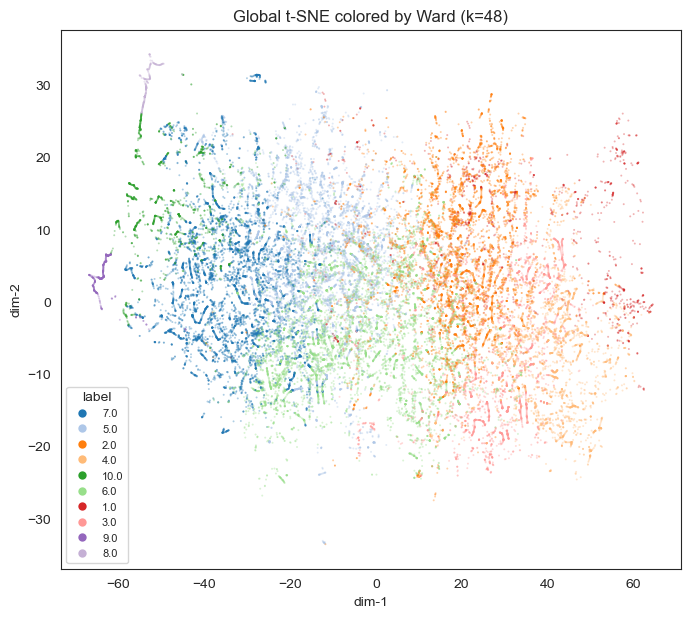

In [53]:
ward_assign = features.WardAssignClustering(params={
    "ward_model": {
        "feature": "global-ward__from__global-tsne",
        "run_id": None,
        "pattern": "model.joblib",
    },
    "artifact": {  # still uses the TSNE templates/scaler space
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
    "scaler": {
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_opentsne_embedding.joblib",
        "key": "scaler",
    },
    "inputset": "social+ego@v1",   # reuse the preset you saved earlier
    "n_clusters": 10,
    "recalc": False,
})

ward_assign_run = dataset.run_feature(
    ward_assign,
    input_kind="inputset",
    input_feature="social+ego@v1",   # tells the runner which inputset drives scope/streaming
)
print("ward-assign run:", ward_assign_run)

viz = features.VizGlobalColored(params={
    "coords": {
        "feature": "global-tsne__from__social+ego@v1",
        "run_id": None,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": "ward-assign__from__global-ward__from__global-tsne",
        "run_id": None,
        "pattern": "*.parquet",
        "load": {"kind": "parquet", "numeric_only": False, "columns": ["cluster"]},
    },
    "coord_key_regex": r"seq=(.+?)(?:_persp=.*)?$",
    "label_key_regex": None,
    "title": "Global t-SNE colored by Ward (k=48)",
})

viz_run_id = dataset.run_feature(viz, input_kind="feature", input_feature="global-tsne")
print("viz run:", viz_run_id)


[feature:viz-global-colored__from__global-tsne] completed run_id=0.1-8597cf5910 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/viz-global-colored__from__global-tsne/0.1-8597cf5910


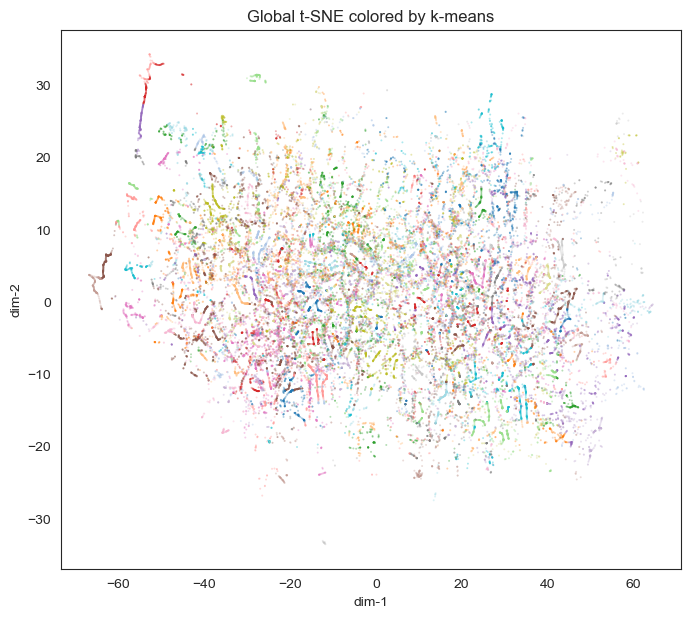

In [ ]:
import importlib, features
importlib.reload(features)

viz = features.VizGlobalColored(params={
    "coords": {
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_tsne_coords_seq=*.npz",
        "load": {"kind": "npz", "key": "Y"},
    },
    "labels": {
        "feature": "global-kmeans__from__global-tsne",
        "run_id": None,
        "pattern": "global_kmeans_labels_seq=*.npz",
        "load": {"kind": "npz", "key": "labels"},
    },
    "coord_key_regex": r"seq=(.+)",
    "label_key_regex": r"seq=(.+)",
    "plot_max": 200_000,
    "title": "Global t-SNE colored by k-means",
})

run_id = dataset.run_feature(viz, input_kind="feature", input_feature="global-tsne")


### use tsne embedding from CALMS

In [80]:
feat_tsne_map = features.GlobalTSNE(params={
    "inputset": "social+ego@v1",
    "map_existing_inputs": True,
    "reuse_embedding": {
        "feature": "calms-global-tsne",
        "run_id": None,  # latest CALMS run
        "pattern": "global_opentsne_embedding.joblib",
    },
    # optional if you want templates copied over:
    # "artifact": {
    #     "feature": "calms-global-tsne",
    #     "pattern": "global_templates_features.npz",
    #     "load": {"kind": "npz", "key": "templates"},
    # },
})
esi_tsne_run = dataset.run_feature(
    feat_tsne_map,
    input_kind="inputset",
    input_feature="social+ego@v1",
)


[feature:global-tsne__from__social+ego@v1] completed run_id=0.2-a613257177 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/global-tsne__from__social+ego@v1/0.2-a613257177


In [ ]:
## assign cluster labels
ward_assign = features.WardAssignClustering(params={
    "ward_model": {
        "feature": "global-ward__from__global-tsne",
        "run_id": ward_run,
        "pattern": "model.joblib",
    },
    "artifact": {  # still uses the TSNE templates/scaler space
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_templates_features.npz",
        "load": {"kind": "npz", "key": "templates"},
    },
    "scaler": {
        "feature": "global-tsne",
        "run_id": None,
        "pattern": "global_opentsne_embedding.joblib",
        "key": "scaler",
    },
    "inputset": "social+ego@v1",   # reuse the preset you saved earlier
    "n_clusters": 10,
    "recalc": False,
})

ward_assign_run = dataset.run_feature(
    ward_assign,
    input_kind="inputset",
    input_feature="social+ego@v1",   # tells the runner which inputset drives scope/streaming
)
print("ward-assign run:", ward_assign_run)

[feature:viz-global-colored__from__global-tsne] completed run_id=0.1-7f4bdf985b -> /Volumes/JD-SSD/ESI-mice/dataset1/features/viz-global-colored__from__global-tsne/0.1-7f4bdf985b
viz run: 0.1-7f4bdf985b
[feature:viz-global-colored__from__global-tsne] completed run_id=0.1-bf5d3f2654 -> /Volumes/JD-SSD/ESI-mice/dataset1/features/viz-global-colored__from__global-tsne/0.1-bf5d3f2654
viz run: 0.1-bf5d3f2654


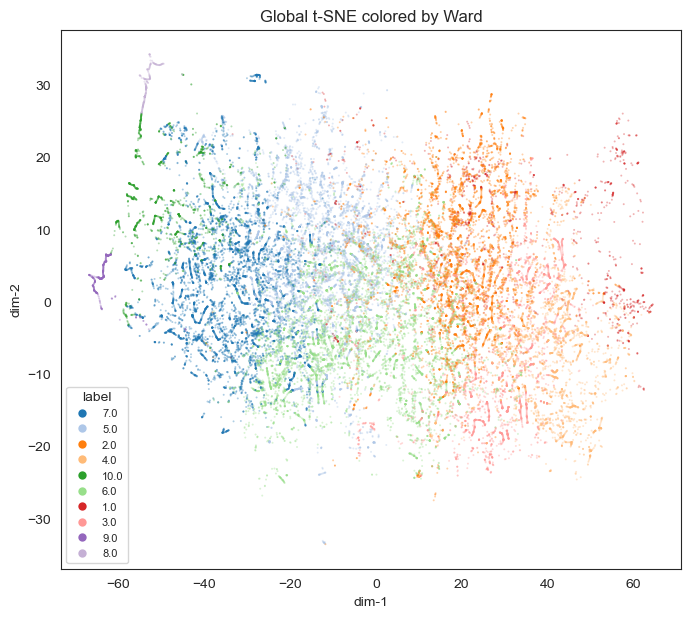

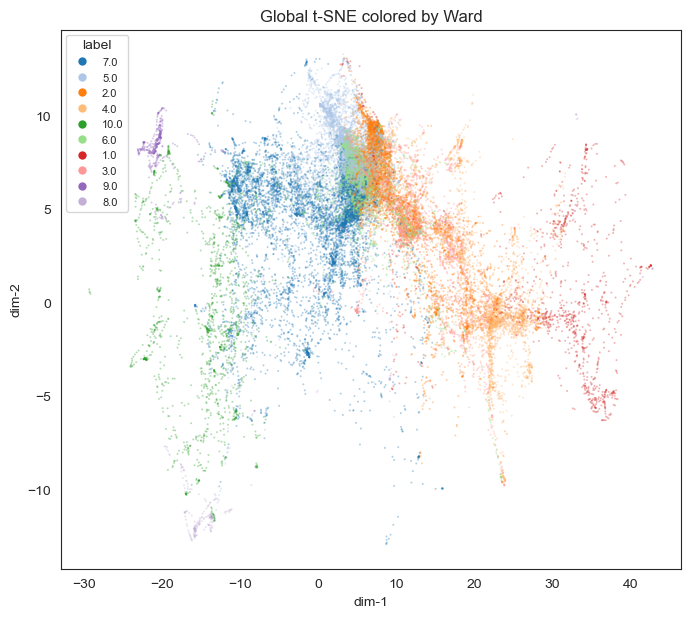

In [82]:
esi_globaltsne = "0.2-419d3315f8"
esi_calms_globaltsne = '0.2-a613257177'
coords_run = esi_calms_globaltsne

for coords_run in [esi_globaltsne, esi_calms_globaltsne]:

    viz = features.VizGlobalColored(params={
        "coords": {
            "feature": "global-tsne__from__social+ego@v1",
            "run_id": coords_run,
            "pattern": "global_tsne_coords_seq=*.npz",
            "load": {"kind": "npz", "key": "Y"},
        },
        "labels": {
            "feature": "ward-assign__from__global-ward__from__global-tsne",
            "run_id": None,
            "pattern": "*.parquet",
            "load": {"kind": "parquet", "numeric_only": False, "columns": ["cluster"]},
        },
        "coord_key_regex": r"seq=(.+)",
        "label_key_regex": r"seq=(.+)",
        "title": "Global t-SNE colored by Ward",
    })

    viz_run_id = dataset.run_feature(viz, input_kind="feature", input_feature="global-tsne")
    print("viz run:", viz_run_id)
